### Distribution of cosine similarities

Plots the distribution of cosine similarities between the filters (or nodes) of a two-layer fully-connected network (MLP). This illustrates the variation of the *first* kind of redundancy (duplicate filter) in neural networks.

#### Setup:

1. The `run_cifar_mlp.py` script trains a two layer network with default settings for 100 epochs.
2. Train 100 networks on Gypsum cluster, each with a different random seed: execute `run_cifar_mlp_multi.sh` on the remote cluster.
3. Download the saved results from Gypsum to local folders: `dl_gypsum_mlp_cosdist.sh`.

In [1]:
# Specify experiment settings
import os
import sys
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import PIL as pil
import sklearn as sk
# local utils
# !find . -name \*.pyc -delete

sys.path.insert(0, "../") # step up to root sourcecode directory

from vis_utils import *
from model_def import *
from model_train import *

%matplotlib inline

expName = 'cifar-MLP_v6.3'
num_filters = 1000

In [2]:
# [Optional] sanity-check: visually inspect the filter weights - smooth, duplicates
for i in range(0,3):
    # load in the saved first-layer weights of each trained network
    w_path = os.path.join('../data', expName, expName+'-'+str(i), 'w-mat.npy')
    w = np.load(w_path)
    
    # plot the weights
    plt.style.use('dark_background')
    plt.suptitle('network: '+expName+'-'+str(i))
    f = vis_linear_weights(w)
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# Calculate the mean weight vector (3072-dim) over all filters and all networks
w_vectors = []

for i in range(0,100):
    # load in the saved first-layer weights of each trained network
    # weights are (num_filters x 3072)
    w_path = os.path.join('../data', expName, expName+'-'+str(i), 'w-mat.npy')
    w = np.load(w_path)
    w = np.reshape(w, [num_filters, -1])
    w_vectors.append(w)  
w_vectors = np.vstack(tuple(w_vectors))
w_mean = w_vectors.mean(axis=0)

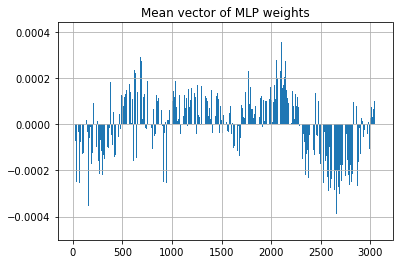

In [3]:
# Plot the mean vector
plt.bar(range(len(w_mean)), w_mean)
plt.grid()
plt.title('Mean vector of MLP weights')

In [5]:
# Calculate the cosine similarities 
# - weights are NOT zero-centered
# - cosine similarities are calculated INTRA-network only
from sklearn.preprocessing import normalize

simil_val = []
for i in range(0,100):
    # load in the first-layer weights for i-th network
    w_path = os.path.join('../data', expName, expName+'-'+str(i), 'w-mat.npy')
    w = np.load(w_path)
    
    # similarity matrix of normalized vectors - 100x100
    w_normalized = normalize(w, norm='l2', axis=1)
    simil_mat = np.dot(w_normalized, w_normalized.T)
    simil_mat.shape
    
    # get the off-diagonal elements
    sz = simil_mat.shape
    offdiag_idx = np.tril_indices(sz[0], k=-1) # below diagonal
    offdiag_val = simil_mat[offdiag_idx]
    simil_val.append(offdiag_val)

simil_val = np.asarray(simil_val).flatten()
hist_simil,hist_bins = np.histogram(simil_val, bins='auto')
# plt.bar(range(len(hist_simil)), hist_simil)
# np.save(os.path.join('./data', expName,'simil-val'), simil_val)

In [105]:
# Cosine similarities between random vectors
rand_simil_val = []
for i in range(0,100):
    # sample random weights
    w_rand = np.random.randn(num_filters, 3072) # gaussian(0,1)
    w_rand = w_rand + w_mean # shift the gaussian's mean to be same as weight vectors'
    
    # similarity matrix of normalized vectors - 100x100
    w_rand_normalized = normalize(w_rand, norm='l2', axis=1)
    rand_simil_mat = np.dot(w_rand_normalized, w_rand_normalized.T)
    
    # get the off-diagonal elements
    sz = rand_simil_mat.shape
    offdiag_idx = np.tril_indices(sz[0], k=-1) # below diagonal
    offdiag_val = rand_simil_mat[offdiag_idx]
    rand_simil_val.append(offdiag_val)

rand_simil_val = np.asarray(rand_simil_val).flatten()
hist_rand_simil,_ = np.histogram(rand_simil_val, bins='auto')

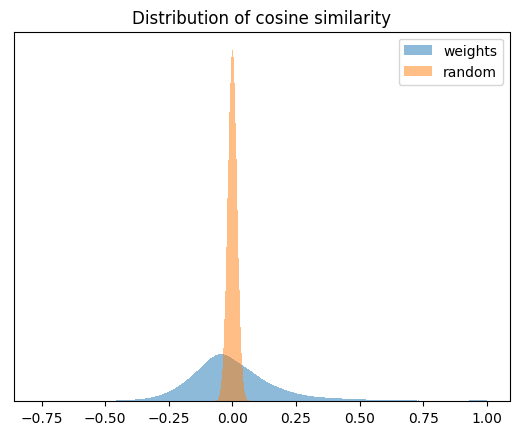

In [106]:
# Plot the distributions of cosine similarity
f = plt.figure()
plt.hist(simil_val, bins=hist_bins, alpha=0.5, label='weights');
plt.hist(rand_simil_val, bins=hist_bins, alpha=0.5, label='random');
plt.legend(loc='upper right')
ax = plt.gca()
# ax.set_yticklabels = []
# ax.set_yticks = []
ax.yaxis.set_visible(False)
plt.title('Distribution of cosine similarity')
f.savefig(os.path.join('./data', expName,'cosine-distribution.png'), bbox_inches='tight')

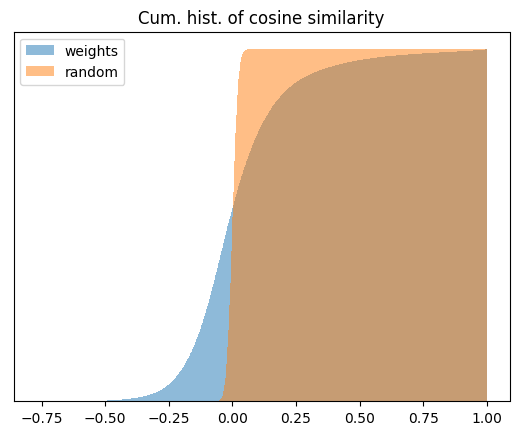

In [107]:
# Plot cumulative histogram of cosine similarity
f = plt.figure()
plt.hist(simil_val, bins=hist_bins, cumulative=True, alpha=0.5, label='weights');
plt.hist(rand_simil_val, bins=hist_bins, cumulative=True, alpha=0.5, label='random');
plt.legend(loc='upper left')
ax = plt.gca()
ax.yaxis.set_visible(False)
plt.title('Cum. hist. of cosine similarity')
f.savefig(os.path.join('./data', expName,'cosine-cum-hist.png'), bbox_inches='tight')

### Function definitions for cosine simlarities

In [4]:
def calc_mean_accuracy(expName, dirPath='./data'):
    '''
        Calculate the mean accuracy from path to experiment
    '''
    acc = []
    for i in range(0,100):
        # load in the saved first-layer weights of each trained network
        # weights are (num_filters x 3072)
        acc_path = os.path.join(dirPath, expName, expName+'-'+str(i), 'net-accu-val.log')
        a = np.loadtxt(acc_path)
        acc = np.append(acc, a[-1]) # test accuracy of last epoch's network  
        
    acc_mean = acc.mean()
    acc_std = acc.std()
    
    return acc_mean, acc_std
    

In [5]:
def calc_mean_w_vect(expName, dirPath='./data'):
    '''
        Calculate the mean vectors of network weight matrices
    '''
    w_vectors = []
    for i in range(0,100):
        # load in the saved first-layer weights of each trained network
        # weights are (num_filters x 3072)
        w_path = os.path.join(dirPath, expName, expName+'-'+str(i), 'w-mat.npy')
        w = np.load(w_path)
        w = np.reshape(w, [num_filters, -1])
        w_vectors.append(w)  
    w_vectors = np.vstack(tuple(w_vectors))
    w_mean = w_vectors.mean(axis=0)
    return w_mean


In [6]:

from sklearn.preprocessing import normalize

def calc_cosine_simil_multi(expName, dirPath='./data'):
    '''
        Calculate the cosine similarities for 100 networks
        - weights are NOT zero-centered
        - cosine similarities are calculated INTRA-network only
    '''
    simil_val = []
    for i in range(0,100):
        # load in the first-layer weights for i-th network
        w_path = os.path.join(dirPath, expName, expName+'-'+str(i), 'w-mat.npy')
        w = np.load(w_path)

        # similarity matrix of normalized vectors - 100x100
        w_normalized = normalize(w, norm='l2', axis=1)
        simil_mat = np.dot(w_normalized, w_normalized.T)

        # get the off-diagonal elements
        sz = simil_mat.shape
        offdiag_idx = np.tril_indices(sz[0], k=-1) # below diagonal
        offdiag_val = simil_mat[offdiag_idx]
        simil_val.append(offdiag_val)

    simil_val = np.asarray(simil_val).flatten()
    print simil_val.shape
    # np.save(os.path.join('./data', expName,'simil-val'), simil_val)
    return simil_val
    

## Plot distribution of cosine similarity

In [14]:
exp_names = ['cifar-MLP_v6.1', 'cifar-MLP_v6.2', 'cifar-MLP_v6.3']
num_filters = [100, 500, 1000]
simil_vals = []

for (i, expName) in enumerate(exp_names):
    simil_vals.append(calc_cosine_simil_multi(expName, '../data'))
    

hist_simil,hist_bins = np.histogram(simil_vals[-1], bins='auto')


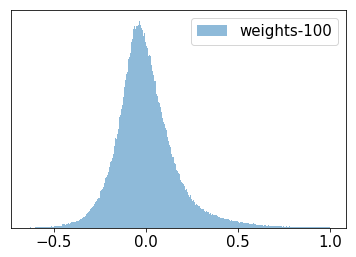

In [14]:
# large fonts
plt.style.use('default')
plt.rcParams.update({'font.size': 15})

f = plt.figure()
plt.hist(simil_vals[0], bins='auto', alpha=0.5, label='weights-100');
plt.legend(loc='upper right')
ax = plt.gca()
ax.yaxis.set_visible(False)
f.savefig(os.path.join('../data', exp_names[0],'cosine-hist-100.png'), bbox_inches='tight')

f = plt.figure()
plt.hist(simil_vals[1], bins='auto', alpha=0.5, label='weights-500');
plt.legend(loc='upper right')
ax = plt.gca()
ax.yaxis.set_visible(False)
f.savefig(os.path.join('../data', exp_names[1],'cosine-hist-500.png'), bbox_inches='tight')

f = plt.figure()
plt.hist(simil_vals[2], bins='auto', alpha=0.5, label='weights-1k');
plt.legend(loc='upper right')
ax = plt.gca()
ax.yaxis.set_visible(False)
f.savefig(os.path.join('../data', exp_names[2],'cosine-hist-1k.png'), bbox_inches='tight')


### Performance over training runs

In [16]:
# Average performance over all runs of network training
acc_mean = []
acc_std = []
for (i, expName) in enumerate(exp_names):
    m, s = calc_mean_accuracy(expName, '../data')
    acc_mean.append(m)
    acc_std.append(s)
    

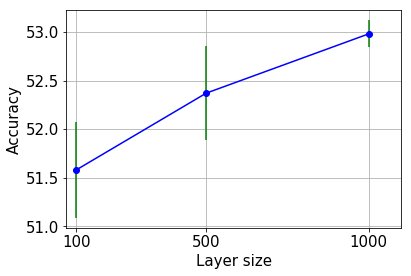

In [19]:
# Plot the average accuracy
f = plt.figure()
plt.errorbar(num_filters, acc_mean, yerr=acc_std, fmt='bo-', ecolor='g')

# for i,j in zip(num_filters, acc_mean):
#     plt.annotate(str(j),xy=(i+3,j-0.1), textcoords='data', wrap=True)

plt.grid()
plt.xticks(num_filters)
plt.xlim(70, 1100)
plt.xlabel('Layer size')
plt.ylabel('Accuracy')
# plt.title('Accuracy with increasing layer size')
f.savefig(os.path.join('../data', exp_names[2],'accuracy-layer-size.png'), bbox_inches='tight')

In [143]:
acc_mean

[51.579999999999998, 52.369999999999997, 52.979999999999997]

### Similarity increase metrics

In [20]:
def calc_percentile_simil(simil_vals, percentile=95):
    prcntSimil = []
    for (i, valOffdiag) in enumerate(simil_vals):
        percentileOffdiag = np.percentile(valOffdiag, percentile)
        prcntSimil = np.append(prcntSimil, percentileOffdiag)
    return prcntSimil

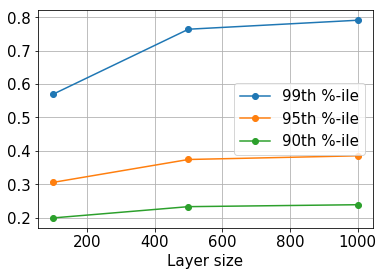

In [21]:
f = plt.figure()
plt.plot(num_filters, calc_percentile_simil(simil_vals, percentile=99), 'o-', label='99th %-ile')
plt.plot(num_filters, calc_percentile_simil(simil_vals, percentile=95), 'o-', label='95th %-ile')
plt.plot(num_filters, calc_percentile_simil(simil_vals, percentile=90), 'o-', label='90th %-ile')
plt.legend()
plt.grid()
plt.xlabel('Layer size')
f.savefig(os.path.join('../data', exp_names[2],'percentile-simil-layer-size.png'), bbox_inches='tight')

In [214]:
# Calculate kurtosis as a measure of heavy-tail of the cosine-similarity distribution
import scipy
kurt = []

for i in range(len(simil_vals)):
    k = scipy.stats.kurtosis(simil_vals[i])
    print k
    kurt.append(k)

3.36727134844
4.15167550038
4.14949657649


In [213]:
f = plt.figure()
plt.plot(num_filters, kurt, 'bo-')

for i,j in zip(num_filters, kurt):
    plt.annotate('%.3f' % j,xy=(i+3,j-0.05), textcoords='data', wrap=True)

plt.xlim(70, 1100)
plt.ylim(3.3, 4.2)
plt.grid()
plt.xticks(num_filters)
plt.xlabel('Layer size')
plt.ylabel('Kurtosis')
plt.title('Heavy-tailed with increasing layer size')
f.savefig(os.path.join('./data', exp_names[2],'kurtosis-simil-layer-size.png'), bbox_inches='tight')

### Surrogate matrix rank

In [72]:
# Normalized trace norm of matrices
from numpy import linalg as LA

def calc_trace_norm_multi(expName, dirPath='./data'):
    '''
        Calculate the trace norms for 100 networks
    '''
    tc_val = []
    for i in range(0,100):
        # load in the first-layer weights for i-th network
        w_path = os.path.join(dirPath, expName, expName+'-'+str(i), 'w-mat.npy')
        w = np.load(w_path)
        sz = w.shape
        tc = LA.norm(w, 'nuc')/np.sqrt((sz[0]*sz[1]))
        tc_val.append(tc)
    
    return tc_val


In [73]:
# Average trace norm over all runs of network training
tc_nets = [[], [], []]
for (i, expName) in enumerate(exp_names):
    tc = calc_trace_norm_multi(expName, '../data')
    tc_nets[i] = tc

In [74]:
mean_tc = [np.mean(x) for x in tc_nets]
std_tc = [np.std(x) for x in tc_nets]

In [79]:
plt.rcParams.update({'font.size': 20})
f = plt.figure()
plt.errorbar(num_filters, mean_tc, yerr=std_tc, fmt='o-', ecolor='g')
plt.xlabel('Layer size')
plt.ylabel('Trace complexity')
plt.grid()
f.savefig(os.path.join('../data', exp_names[2],'trace-complexity-layer-size.pdf'), bbox_inches='tight')
f.savefig(os.path.join('../data', exp_names[2],'trace-complexity-layer-size.png'), bbox_inches='tight')